<a href="https://colab.research.google.com/github/Computational-physics-with-learning/Score-based-diffusion/blob/main/ScoreBasedDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Download stuff
%%capture
!wget -nc https://github.com/Computational-physics-with-learning/Score-based-diffusion/raw/main/ckpt.pth
!wget -nc https://github.com/Computational-physics-with-learning/Score-based-diffusion/raw/main/ForwardOperator_CT_28x28_30angles.npy
!wget -nc https://github.com/Computational-physics-with-learning/Score-based-diffusion/raw/main/walnut.PNG

import warnings; warnings.filterwarnings('ignore', message='To copy construct from a tensor,*')
import functools, tqdm
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torchvision.datasets import MNIST, KMNIST
MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
KMNIST('.', train=True, transform=transforms.ToTensor(), download=True)

import math 
device = 'cuda' 


# Score-based Diffusion Models 

Most of this colab is based on https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing#scrollTo=LZC7wrOvxLdL

What is in this notebook:
- Setting up special cases for the forward SDE (VE-SDE, VP-SDE)
- Implement the training loss
- Architecture of the score network
- Different sampling methods: Euler-Maruyama, ODE Sampling 
- Sample from the posterior $p(x|y)$ 

## Overview

In 2019/2020 two generative models were proposed:
- Song & Ermon, *Generative Modeling by Estimating Gradients of the Data Distribution* (2019): Score matching with Langevin dynamics **[SMLD]**
- Ho et al., *Denoising Diffusion Probabilistic Models* (2020) **[DDPM]**

Both were working in a similar way: sequentially adding more and more noise to data, and then learning to reverse this process. Song et al. (2021) showed that both of these models can be understand in the framework of stochastic differential equations. All of the theory in this notebook is based on this work:

- Song et al., *Score-based generative modeling through stochastic differential equations* (2021)



![sde schematic](https://drive.google.com/uc?id=1Ptvb790eQRYMHLnDGBeYZK9A2cF-JMEP)

# Notation and Reminder



We start by definind a **SDE**

$$ d \mathbf{x} = f(\mathbf{x}, t) dt + g(t) d \mathbf{w} $$

with:
  - $f(\cdot, t)$ the drift coefficient 
  - $g(t)$ diffusion coefficient

and $\mathbf{w}$ is Brownian motion. The drift $f$ and diffusion $g$ are choosen in such a way that the distribution $p_T$ of the diffused $x(T) \sim p_T$ should be close to some simple and easy to handle distribution, i.e. a Gaussian. 

An important result tells us, that the reverse of a diffusion process is still a diffusion process is given by this SDE: 

$$ d \mathbf{x} = [f(\mathbf{x}, t) - g(t)^2 \nabla_x \log p_t(\mathbf{x})] dt + g(t) d \bar{\mathbf{w}} $$

which runs backward in time, i.e. $dt$ is a infinitesimal negative time step and $\bar{\mathbf{w}}$ is Brownian motion. Rember that $f$ and $g$ are choosen in advance, so we need *only* to estimate the score of $p_t(\mathbf{x})$ for every $t \in [0,T]$, i.e. we would like to find a model $s_\theta: \mathbb{R}^n \times [0,T] \to \mathbb{R}^n$ minimizing the score matching objective:

$$ \min_\theta \mathbb{E}_{t \sim U(0,T)} \lambda(t) \mathbb{E}_{x(t) \sim p_t(x)} [ \| s_\theta(\mathbf{x}(t), t) - \nabla_x \log p_t(\mathbf{x}(t)) \|_2^2]. $$

This is infeasible as the score is unknown. However, we can minimize the *denoising score matching*  [(Vincent, 2011)](https://www.iro.umontreal.ca/~vincentp/Publications/smdae_techreport.pdf) objective which results in the same minimizer: 

$$ \min_\theta \mathbb{E}_{t \sim U(0,T)} \lambda(t) \mathbb{E}_{x(0) \sim p_0(x)} \mathbb{E}_{x(t) \sim p_{0t}(x(t)|x(0))} [ \| s_\theta(\mathbf{x}(t), t) - \nabla_x \log p_{0t}(\mathbf{x}(t)|\mathbf{x}(0) ) \|_2^2] $$

where $p_{0t}(x(t)|x(0))$ is the transition probability / pertubation kernel. When the drift $f$ is affine, this can be calculated analytically.  


# How to choose the diffusion process? 

The models used in **[SMLD]** and **[DDPM]** can be seen as discretizations of two different SDE, the Variance Exploding *(VE-SDE)* and Variance Preserving *(VP-SDE)* respectively. Most authors use one of these two SDEs for the forward diffusion process. 


## Variance Exploding SDE (VE-SDE)

The variance exploding SDE is given by

$$ d \mathbf{x} = \sqrt{\frac{d [\sigma^2(t)]}{d t}} d \mathbf{w}, \quad t \in [0,1],$$

i.e. we have no drift coefficient $f(x, t) = 0$. Most authors choose $T=1$ for VE-SDE and set $\sigma^2(t)$ accordingly. Under a specific choice for $\sigma^2(t)$ in Song et al. we get

$$ d \mathbf{x} = \sigma_\text{min} \left( \frac{\sigma_\text{max}}{\sigma_\text{min}} \right)^t \sqrt{2 \log \frac{\sigma_\text{max}}{\sigma_\text{min}}} d \mathbf{w}.$$

And if $\sigma_\text{max}$ is suffiently large we have $$p_1 \approx \mathcal{N}(0, \sigma_\text{max}^2 I).$$ 

The perturbation kernel is a Gaussian and can be given in closed form:

$$ p_{0t}(x(t)|x(0)) = \mathcal{N}\left(x(t); x(0), \sigma_\text{min}^2 \left(\frac{\sigma_\text{max}}{\sigma_\text{min}}\right)^{2t} I\right) $$

For the denoising score matching objective we need the score of the perturbation kernel. This can be calculated as

$$ \nabla_{x(t)} \log p_{0t}(x(t) | x(0)) = - \frac{1}{\sigma_\text{min}^2 (\frac{\sigma_\text{max}}{\sigma_\text{min}})^{2t} } (x(t) - x(0)) .$$

We further can write $x(t) \sim p_{0t}(x(t)|x(0))$ as 

$$ x(t) = x(0) + \sigma_\text{min} \left(\frac{\sigma_\text{max}}{\sigma_\text{min}}\right)^{t}  z, \quad z \sim \mathcal{N}(0,I) .$$

Combining these two equations: 

$$ \nabla_{x(t)} \log p_{0t}(x(t) | x(0)) = - \frac{z}{\sigma_\text{min} \left( \frac{\sigma_\text{max}}{\sigma_\text{min}}\right)^t }, \quad z \sim \mathcal{N}(0,I) .$$

We use $\lambda(t)= \sigma_\text{min}^2 \left( \frac{\sigma_\text{max}}{\sigma_\text{min}}\right)^{2t}$ and the loss function becomes 

$$ \min_\theta \mathbb{E}_{t \sim U(0,1)} \mathbb{E}_{x(0) \sim p_0(x)} \mathbb{E}_{z \sim \mathcal{N}(0,I)} \left[ \left\| \sigma_\text{min} \left(\frac{\sigma_\text{max}}{\sigma_\text{min}}\right)^{t} s_\theta\left(x(0) + \sigma_\text{min} \left(\frac{\sigma_\text{max}}{\sigma_\text{min}}\right)^{t}  z, t\right) +z \right\|_2^2\right] .$$

Let $\sigma(t) = \sigma_\text{min} \left(\frac{\sigma_\text{max}}{\sigma_\text{min}}\right)^{t}$ we can write it a bit more compact: 

$$ \min_\theta \mathbb{E}_{t \sim U(0,1)} \mathbb{E}_{x(0) \sim p_0(x)} \mathbb{E}_{z \sim \mathcal{N}(0,I)} \left[ \left\| \sigma(t) s_\theta\left(x(0) + \sigma(t)  z, t\right) +z \right\|_2^2\right] $$

So, in pseudo code 

```
#x <- get from dataset
t = torch.rand(x.shape[0])
z = torch.randn_like(x)
sigma_t = marginal_prob_std(t)
perturbed_x = x + sigma_t * z 
score = model(perturbed_x, t)
loss = torch.mean(torch.sum((std * score + z)**2))
```


## Variance Preserving SDE (VP-SDE)

The variance preserving SDE is given by

$$ d \mathbf{x} = - \frac{1}{2} \beta(t) x d t + \sqrt{\beta(t)} d \mathbf{w}, \quad t \in [0,1],$$

For the VP-SDE we have both a non-zero drift and diffusion term. The **DDPM** can be seen as a discrezisation of this SDE with the specific choice $\beta(t) = \beta_\text{min} + t (\beta_\text{max} - \beta_\text{min})$. 

And if $\beta_\text{max}$ is suffiently large we have $$p_1 \approx \mathcal{N}(0, 1).$$ 

The perturbation kernel is also a Gaussian and can be given in closed form. However it looks slightly more messy:

$$ \begin{align} p_{0t}(x(t)|x(0)) &= \mathcal{N}\left(x(t); \exp(-\tfrac14 t^2 (\beta_\text{max} - \beta_\text{min} - \tfrac12 t \beta_\text{min}) x(0), (1 -\exp(-\tfrac12 t^2 (\beta_\text{max} - \beta_\text{min} - t \beta_\text{min}))  I\right) 
\\ &= 
\mathcal{N}(x(t); \beta_\text{mean}(t) x(0), \beta_\text{std}(t)^2 I). \end{align}$$

For the denoising score matching objective we need the score of the perturbation kernel. This can be calculated as

$$ \nabla_{x(t)} \log p_{0t}(x(t) | x(0)) = - \frac{1}{\beta_\text{std}(t)^2} (x(t) - \beta_\text{mean}(t) x(0)). $$

We further can write $x(t) \sim p_{0t}(x(t)|x(0))$ as 

$$ x(t) = \beta_\text{mean}(t) x(0) + \beta_\text{std}(t) z, \quad z \sim \mathcal{N}(0,I). $$

Combining these two equations: 

$$ \nabla_{x(t)} \log p_{0t}(x(t) | x(0)) = - \frac{z}{\beta_\text{std}(t)^2}, \quad z \sim \mathcal{N}(0,I). $$

We use $\lambda(t)= \beta_\text{std}(t)^2$ and the loss function becomes 

$$ \min_\theta \mathbb{E}_{t \sim U(0,1)} \mathbb{E}_{x(0) \sim p_0(x)} \mathbb{E}_{z \sim \mathcal{N}(0,I)} \left[ \left\| \beta_\text{std}(t) s_\theta\left( \beta_\text{mean}(t)x(0) + \beta_\text{std}(t)  z, t\right) +z \right\|_2^2\right] .$$

For the following experiments we use the VP-SDE with $\beta_\text{min} = 0.1$ and $\beta_\text{max} = 20$.



### Score model $s_\theta$ as a denoiser

If we look again at the loss function the model should fulfill 

$$ z \approx - \beta_\text{std}(t) s_\theta(x(t), t). $$

We can write $x(t) = \beta_\text{mean}(t) x(0) + \beta_\text{std}(t) z$ with $ z \sim \mathcal{N}(0,I)$ combining these we get: 

$$ x(0) = \frac{x(t) + \beta_\text{std}(t)^2 s_\theta(x(t), t)}{ \beta_\text{mean}(t)}. $$

So, the score model should be the residual of the noisy image $x(t)$ and the clean image $x(0)$. Apparently U-Nets are very good at this type of task, so most authors choose a U-Net like architecture for $s_\theta$.


# Implementation

In [2]:
#@title Set up SDE

# based on the variance exploding SDE
# the derivations are given in [https://arxiv.org/pdf/2011.13456.pdf] Appendix C
def marginal_prob_std(t, beta_min=0.1, beta_max=20):
  """Compute the **standard deviation** of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.
  
  Returns:
    The standard deviation.
  """    
  t = torch.tensor(t, device=device)
  log_mean_coeff = -0.25 * t ** 2 * (beta_max - beta_min) - 0.5 * t * beta_min
  return torch.sqrt(1. - torch.exp(2. * log_mean_coeff))

def marginal_prop_mean(t, beta_min=0.1, beta_max=20):
  """Compute the **mean** of $p_{0t}(x(t) | x(0))$.

  Args:    
    t: A vector of time steps.

  Returns:
    The scaling for the mean.
  """   
  t = torch.tensor(t, device=device)
  log_mean_coeff = -0.25 * t ** 2 * (beta_max - beta_min) - 0.5 * t * beta_min
  return torch.exp(log_mean_coeff)

def diffusion_coeff(t, beta_min=0.1, beta_max=20):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
  
  Returns:
    The vector of diffusion coefficients.
  """
  t = torch.tensor(t, device=device)
  beta_t = beta_min + t * (beta_max - beta_min)
  return torch.sqrt(beta_t)

def drift_coeff(t, beta_min=0.1, beta_max=20):
  """Compute the drift coefficient of our SDE.

  Args:
    t: A vector of time steps.
  
  Returns:
    The vector of drift coefficients.
  """
  t = torch.tensor(t, device=device)
  beta_t = beta_min + t * (beta_max - beta_min)
  return -0.5 * beta_t

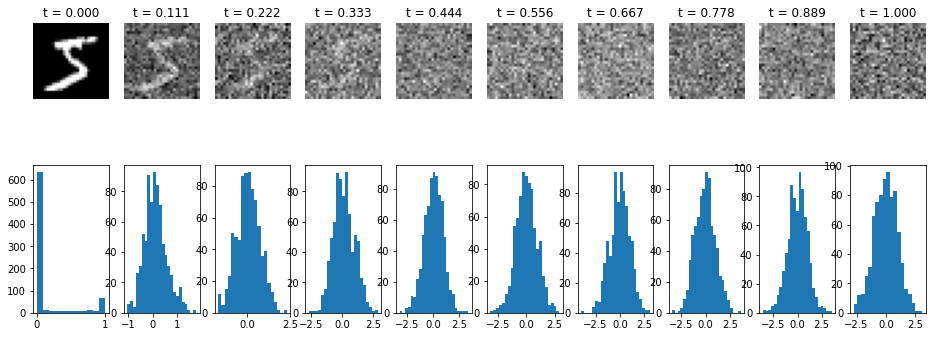

In [3]:
#@title Visualize forward diffusion process
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)

x = dataset[0][0]
T = 1.
t = np.linspace(0, T, 10)

fig, axes = plt.subplots(2, len(t), figsize=(16,6))

for idx, t_ in enumerate(t):

    std = marginal_prob_std(t_).cpu()
    mean = marginal_prop_mean(t_).cpu()
    z = torch.randn_like(x)
    perturbed_x = mean * x + z * std

    axes[0, idx].imshow(perturbed_x[0,:,:], cmap="gray")
    axes[0, idx].axis("off")
    axes[0, idx].set_title("t = {:.3f}".format(t_))
    axes[1, idx].hist(perturbed_x[0,:,:].ravel(), bins="auto")


plt.show()

In [4]:
#@title Loss Function
def loss_fn(model, x, marginal_prob_std, marginal_prop_mean, eps=1e-5, T=1.):

    """The loss function for training score-based generative models.

    Args:
        model: A PyTorch model instance that represents a 
        time-dependent score-based model.
        x: A mini-batch of training data.    
        marginal_prob_std: A function that gives the standard deviation of 
        the perturbation kernel.
        eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    mean = marginal_prop_mean(random_t)
    perturbed_x = mean[:, None, None, None] * x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
    
    return loss



## Time-Dependent Score-Based Model

No restrictions on the architecutre, expect that the output $s_\theta(x, t)$ should have the same size as $x$. 

Things that are used in the literature: 

### U-Net Backbone 

Using a U-Net architecture works well for image-to-image task. Most authors include some attention blocks in the low resolution parts of the U-Net. Also the specific choice of upsampling and downsampling operations is heavily inspired by the GAN literature. 

### Incorporate time information via Gaussian features

 For each time step $t$ the Gaussian feature is defined by 
$$ [\sin(2 \pi \omega t); \cos(2 \pi \omega t)]. $$

This can either be random (but fixed) $\omega \sim \mathcal{N}(0, s^2 I)$, or just set to a specific vector. 

So, if $\omega \in \mathbb{R}^d$ and $t \in \mathbb{R}$ we increase the dimensionalty to $[\sin(2 \pi \omega t); \cos(2 \pi \omega t)] \in \mathbb{R}^{2d}$. Typically $d=32$ or $d=64$ is choosen. 

These features are then often incoporated as a bias to convolutional layers 

```
conv = torch.nn.Conv2d(..., output_channels = c_out, bias=False)
time_step_network = nn.Linear(2*d, c_out)
gaussian_random_features = torch.cat([torch.sin(2 * pi * omega * t), torch.cos(2 *pi * omega * t)])
h = activation(conv(x) + time_step_network(gaussian_random_features_t))
```


### Rescale output of the U-Net 

Looking at the loss function we see the term $\sigma(t) s_\theta(x(0) + \sigma(t) z, t) + z$, so 

$$ s_\theta(x(0) + \sigma(t) z, t) \approx - z / \sigma(t). $$

As $\sigma(t)$ is known, we simply rescale the output of the U-Net by $1/\sigma(t)$ to be in the right range. 



In [5]:
#@title Setup Network

import torch.nn as nn
import torch.nn.functional as F

def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Sequential(nn.SiLU(), nn.Linear(input_dim, output_dim))
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed_dim = embed_dim
    self.emb_layers = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.SiLU(),
            nn.Linear(embed_dim,embed_dim))

    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.emb_layers(timestep_embedding(t, self.embed_dim))
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [6]:

beta_min = 0.1
beta_max = 20 

marginal_prob_std_fn = functools.partial(marginal_prob_std, 
                                        beta_min=beta_min, beta_max=beta_max)
marginal_prob_mean_fn = functools.partial(marginal_prop_mean, 
                                        beta_min=beta_min, beta_max=beta_max)
diffusion_coeff_fn = functools.partial(diffusion_coeff, 
                                        beta_min=beta_min, beta_max=beta_max)
drift_coeff_fn = functools.partial(drift_coeff, 
                                        beta_min=beta_min, beta_max=beta_max)

score_model = ScoreNet(marginal_prob_std=marginal_prob_std_fn)


print("Number of Parameters: ", sum([p.numel() for p in score_model.parameters()]))

score_model = score_model.to(device)


Number of Parameters:  1181089


In [7]:
#@title Train loop 
n_epochs =   50
## size of a mini-batch
batch_size = 64
## learning rate
lr=1e-4

try:
    ## Load the pre-trained checkpoint from disk.
    ckpt = torch.load('ckpt.pth', map_location=device)
    score_model.load_state_dict(ckpt)

except FileNotFoundError:

    optimizer = Adam(score_model.parameters(), lr=lr)
    tqdm_epoch = tqdm.notebook.trange(n_epochs)
    trainingdata_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    print("Start Training")
    for epoch in tqdm_epoch:
        avg_loss = 0.
        num_items = 0
        for x, y in trainingdata_loader:
            x = x.to(device)    
            loss = loss_fn(score_model, x, marginal_prob_std_fn, marginal_prob_mean_fn)
            optimizer.zero_grad()
            loss.backward()    
            optimizer.step()
            avg_loss += loss.item() * x.shape[0]
            num_items += x.shape[0]
    # Print the averaged training loss so far.
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'ckpt.pth')
score_model.eval();


# Sampling from the reverse SDE

Remember the reverse SDE with our score based model is given by 

$$ d \mathbf{x} = [f(\mathbf{x}, t) - g(t)^2 s_\theta(\mathbf{x}, t)] dt + g(t) d \bar{\mathbf{w}}, \quad t \in [0,1] $$

To sample from $p_0 \approx p_\text{data}$ we first need to sample a $x(1) \sim \mathcal{N}(0,I) \approx p_1$ and then solve the reverse SDE. To solve the reverse SDE any numerical solver can be used.

**Sampling = Solving a SDE**

The simplest one is the Euler-Maruyama solver: 

1. Equidistant partition of time interval [0,1] into $N$ subintervals with step size $\Delta t = 1/N$
2. Sample $x(1) \sim \mathcal{N}(0,I)$
3. Simulate reverse SDE: 
$$ x_{t - \Delta t} = x_t - [f(x_t, t) - g(t)^2 s_\theta(x_t, t)] \Delta t + \sqrt{\Delta t} g(t) z, \quad z \sim \mathcal{N}(0,I) .$$

For the VP-SDE we get the scheme:

$$  x_{t - \Delta t} = x_t - [-1/2 \beta(t) x_t - \beta(t) s_\theta(x_t, t)] \Delta t + \sqrt{\beta(t) \Delta t }  z, \quad z \sim \mathcal{N}(0,I) .$$

Many work has been done on using different SDE solver, these are often inspired by existing ODE solvers:
- Predictor-Corrector Methods by Song et al. 
- stochastic Runge-Kutta Methods (i.e. [Karras et al.](https://arxiv.org/pdf/2206.00364.pdf))

And there exist many methods on building faster solvers for example using adaptive step-sizes, etc.


In [8]:
def Euler_Maruyama_sampler(score_model, 
                           drift_coeff,
                           diffusion_coeff, 
                           batch_size=64, 
                           num_steps=500, 
                           device='cuda', 
                           eps=1e-3,
                           T = 1.):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps. 
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.
  
  Returns:
    Samples.    
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) * T 
  time_steps = torch.linspace(T, eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  print(step_size)
  x = init_x
  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step

      g = diffusion_coeff(batch_time_step)
      f = drift_coeff(batch_time_step)[:, None, None, None]
      mean_x = x - (f*x - (g**2)[:, None, None, None] * score_model(x, batch_time_step)) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      

  # Do not include any noise in the last sampling step.
  return mean_x

tensor(0.0013, device='cuda:0')


  0%|          | 0/800 [00:00<?, ?it/s]

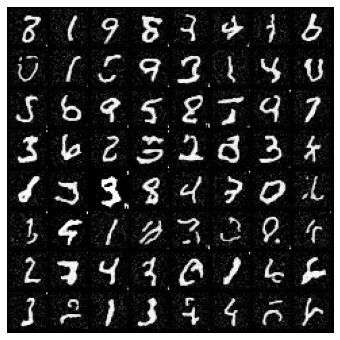

In [9]:
#@title Visualise examples
sample_batch_size = 64 
T = 1.
## Generate samples using the specified sampler.
samples = Euler_Maruyama_sampler(score_model, 
                           drift_coeff=drift_coeff_fn,
                           diffusion_coeff=diffusion_coeff_fn, 
                           batch_size=sample_batch_size, 
                           num_steps=800, 
                           device='cuda', 
                           eps=1e-5,
                           T=T)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()


## Probability Flow ODE

For all diffusion processes, there exist a corresponding **ODE** with the same marginal probability densities $p_t$ for $t=0, \dots, 1$. It is given by:

$$ d \mathbf{x} = [f(\mathbf{x},t) - \tfrac12 g(t)^2 \nabla_x \log p_t(\mathbf{x})] dt $$

Song et al. call this **probability flow ODE**. We can also sample from the reverse diffusion process by solving this ODE reverse in time:

$$ x_\text{sample} = \text{ODESolve}(x(1) = z, s_\theta, [1,0])  $$

with $z \sim \mathcal{N}(0,I) \approx p_1$ and we can use any black-box ODE solver.

For example we use the inbuilt Runge-Kutta solver by `scipy.integrate`.

In [10]:
#@title Setting up ODE sampler

from scipy import integrate

## The error tolerance for the black-box ODE solver
def ode_sampler(score_model,
                drift_coeff,
                diffusion_coeff,
                batch_size=64, 
                atol=1e-5 , 
                rtol=1e-5 , 
                device='cuda', 
                z=None,
                eps=1e-3,
                T=1.):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * T
  else:
    init_x = z
    
  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))    
    with torch.no_grad():    
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)
  
  def ode_func(t, x):        
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t    
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    f = drift_coeff(torch.tensor(t)).cpu().numpy()
    return f*x -0.5 * (g**2) * score_eval_wrapper(x, time_steps)
  
  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (T, eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')  
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x


Number of function evaluations: 200


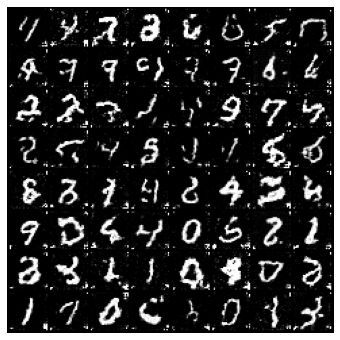

In [11]:
sample_batch_size = 64 

## Generate samples using the specified sampler.
samples = ode_sampler(score_model, 
                           drift_coeff=drift_coeff_fn,
                           diffusion_coeff=diffusion_coeff_fn, 
                           batch_size=64, 
                           device='cuda', 
                           eps=1e-4,
                           atol=1e-6)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

This connection of score-based diffusion models to ODEs has recently lead to the development of [flow matching](https://arxiv.org/pdf/2210.02747.pdf).

### Solving Inverse Problems 

Assume we have a linear forward operator $A: \mathbb{R}^n \to \mathbb{R}^m$ and noisy measurements $y^\delta = A x + \eta$ with Gaussian noise $\eta \sim \mathcal{N}(0,\sigma^2 I)$.

In order to sample from the posterior $p(x|y)$ we can use the conditional reverse SDE:

$$ d \mathbf{x} = [f(\mathbf{x}, t) - g(t)^2 \nabla_x \log p_t(x|y)] dt + g(t) d \bar{\mathbf{w}}, \quad t \in [0,1] .$$

We can decompose $p_t(x|y)$ into prior and likelihood using Bayes' Theorem

$$ \begin{align} \nabla_x \log p_t(x|y) &= \nabla_x \log p_t(x) + \nabla_x \log p_t(y|x) \\ &\approx s_\theta(x, t) + \nabla_x \log p_t(y|x). \end{align}$$

Note: 

The approximation $\nabla_x \log p_t(y|x) \approx \sigma^{-2} A^*( A x - y)$ is only valid for $t=0$. [Jalal et al.](https://arxiv.org/pdf/2108.01368.pdf) use the approximation:

$$\nabla_x \log p_t(y|x) \approx \gamma(t) \sigma^{-2} A^*(A x - y)$$

with $\gamma_t$ monotone decreasing and $\gamma(1)=0$, $\gamma(0)=1$. 

Using this approximation we sample from: 

$$ d \mathbf{x} = [f(\mathbf{x}, t) - g(t)^2 (s_\theta(\mathbf{x},t) + \gamma(t) \sigma^{-2} A^*(A x - y))] dt + g(t) d \bar{\mathbf{w}}, \quad t \in [0,1]. $$


In [12]:
#@title Create ray trafo matrix

try:
    A = np.load("ForwardOperator_CT_28x28_30angles.npy")
except FileNotFoundError:
    # note I haven't actually installed odl!
    # run: !pip install https://github.com/odlgroup/odl/archive/master.zip --upgrade
    import odl 
    from odl import uniform_discr
    import odl.tomo
    from odl.operator.oputils import matrix_representation
    import numpy as np 

    num_angles = 30
    domain = uniform_discr([-1,-1], [1,1], (28,28), dtype=np.float32)

    geometry = odl.tomo.parallel_beam_geometry(domain, num_angles=num_angles)

    ray_trafo = odl.tomo.RayTransform(domain, geometry)

    A = matrix_representation(ray_trafo)

    A = A.reshape(A.shape[0]*A.shape[1], A.shape[2]*A.shape[3])

    np.save("ForwardOperator_CT_28x28_30angles.npy", A)
A = torch.from_numpy(A).float()
print(A.shape)

torch.Size([1230, 784])


In [13]:
def condEuler_Maruyama_sampler(score_model, 
                           A,
                           y,
                           penalty,
                           drift_coeff,
                           diffusion_coeff, 
                           num_steps=500, 
                           device='cuda', 
                           eps=1e-3,
                           T = 1.):
  batch_size = y.shape[0]
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) * T 
  time_steps = torch.linspace(T, eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for idx, time_step in tqdm.notebook.tqdm(enumerate(time_steps), total=len(time_steps)):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step

      g = diffusion_coeff(batch_time_step)
      f = drift_coeff(batch_time_step)[:, None, None, None]

      s = score_model(x, batch_time_step) 
      data_consistency = - idx/len(time_steps)*torch.matmul(torch.matmul(x.view(-1, 784), A.T) - y, A)
      data_consistency = data_consistency.view(-1, 1, 28, 28)

      mean_x = x - (f*x - (g**2)[:, None, None, None] * (s + penalty*data_consistency) ) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      

  # Do not include any noise in the last sampling step.
  return mean_x

  0%|          | 0/1500 [00:00<?, ?it/s]

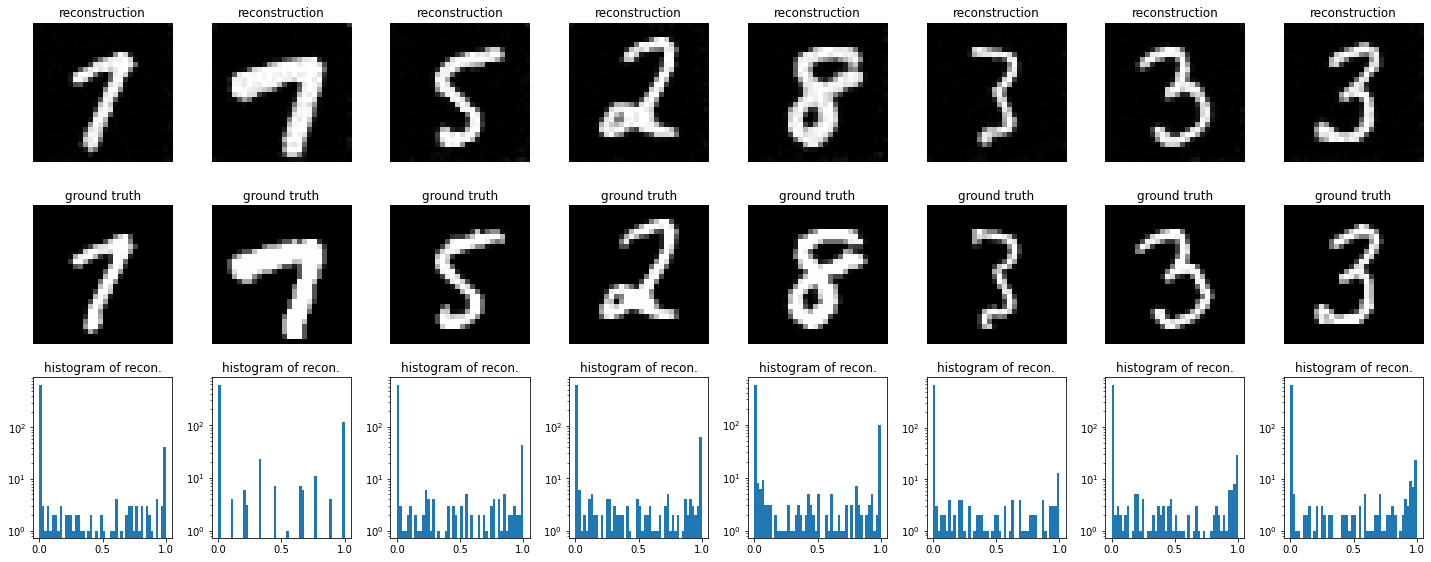

In [14]:
batch_size = 8
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

x, _ = next(iter(data_loader))
x = x.to(device)
A = A.to(device)

y = torch.matmul(x.view(-1, 784), A.T)
y_delta = y + 0.05*torch.mean(torch.abs(y), dim=1, keepdim=True)*torch.randn_like(y,device=device)

penalty = 100.

samples = condEuler_Maruyama_sampler(score_model, 
                           A=A,
                           y=y_delta,
                           penalty=penalty,
                           drift_coeff=drift_coeff_fn,
                           diffusion_coeff=diffusion_coeff_fn, 
                           num_steps=1500, 
                           device='cuda', 
                           eps=1e-4,
                           T = 1.)
samples = torch.clamp(samples, 0, 1)

fig, axes = plt.subplots(3, samples.shape[0],figsize=(20,8))

for i in range(samples.shape[0]):

  axes[0,i].imshow(samples[i,0,:,:].cpu().numpy(), cmap="gray")
  axes[0,i].axis("off")
  axes[0,i].set_title("reconstruction")
  axes[1,i].imshow(x[i, 0,:,:].cpu().numpy(), cmap="gray")
  axes[1,i].axis("off")
  axes[1,i].set_title("ground truth")

  axes[2,i].hist(x[i, 0,:,:].cpu().numpy().ravel(), bins=50)
  axes[2,i].set_yscale('log')

  axes[2,i].set_title("histogram of recon.")

plt.tight_layout()

### Projection sampling 

Many authors employ a projection step during sampling 

$$ \tilde{x}_{t -\Delta t} = k(x_t, s_\theta, t) \\ x_{t- \Delta t} = A_1 y^\delta + A_2 \tilde{x}_{t -\Delta t} $$

with $k$ for example one Euler-Maruyama step to go from $p_t$ to $p_{t - \Delta t}$ and a projection step for enforce data consistency. This could be a gradient descent step, i.e. 

$$ x_{t- \Delta t} = \tilde{x}_{t -\Delta t} - \lambda A^* (A \tilde{x}_{t -\Delta t} - y^\delta) $$

or

$$ x_{t- \Delta t} = A^\dagger y + (I - A^\dagger A) \tilde{x}_{t -\Delta t}$$

where $I - A^\dagger A$ is the projection on the null space of $A$. 

Here we choose $A^\dagger = (A^* A + \alpha I)^{-1} A^*$ with $\alpha=0.1$.

In [15]:
def projection_sampler(score_model, 
                           A,
                           y,
                           penalty,
                           drift_coeff,
                           diffusion_coeff, 
                           num_steps=500, 
                           device='cuda', 
                           eps=1e-3,
                           T = 1.):
  batch_size = y.shape[0]
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) * T 
  time_steps = torch.linspace(T, eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x

  tik_p = 0.1
  ATAinv = torch.linalg.inv(torch.matmul(A.T, A) + tik_p*torch.eye(A.shape[1], device=device))
  Adagger = torch.matmul(ATAinv, A.T)
  AdaggerA = torch.matmul(Adagger, A) 

  x_reco = torch.matmul(Adagger, y.T).T
  x_reco = x_reco.reshape(x_reco.shape[0], 1, 28,28)

  with torch.no_grad():
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step

      g = diffusion_coeff(batch_time_step)
      f = drift_coeff(batch_time_step)[:, None, None, None]

      s = score_model(x, batch_time_step) 

      mean_x = x - (f*x - (g**2)[:, None, None, None] * s ) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

      # projection step
      x_proj = torch.matmul(AdaggerA, x.view(-1, 784).T).T
      x_proj = x - x_proj.reshape(x_proj.shape[0], 1, 28, 28)
      x = x_reco + x_proj
      
  return x, x_reco

  0%|          | 0/500 [00:00<?, ?it/s]

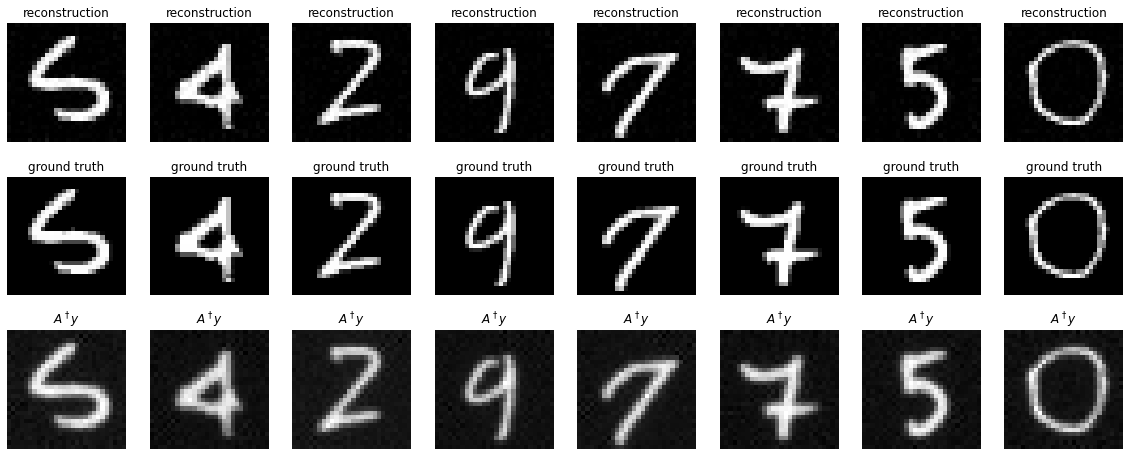

In [16]:
x, _ = next(iter(data_loader))
x = x.to(device)
A = A.to(device)

y = torch.matmul(x.view(-1, 784), A.T)
y_delta = y + 0.05*torch.mean(torch.abs(y), dim=1, keepdim=True)*torch.randn_like(y,device=device)

samples, Adagger_y = projection_sampler(score_model, 
                           A=A,
                           y=y_delta,
                           penalty=penalty,
                           drift_coeff=drift_coeff_fn,
                           diffusion_coeff=diffusion_coeff_fn, 
                           num_steps=500, 
                           device='cuda', 
                           eps=1e-3,
                           T = 1.)
samples = torch.clamp(samples, 0, 1)

fig, axes = plt.subplots(3, samples.shape[0],figsize=(20,8))

for i in range(samples.shape[0]):

  axes[0,i].imshow(samples[i,0,:,:].cpu().numpy(), cmap="gray")
  axes[0,i].axis("off")
  axes[0,i].set_title("reconstruction")
  axes[1,i].imshow(x[i, 0,:,:].cpu().numpy(), cmap="gray")
  axes[1,i].axis("off")
  axes[1,i].set_title("ground truth")
  
  axes[2,i].imshow(Adagger_y[i, 0,:,:].cpu().numpy(), cmap="gray")
  axes[2,i].axis("off")
  axes[2,i].set_title(r"$A^\dagger y$")
plt.show()

### Generalization: How does a score model trained on MNIST generalize to KMNIST? 



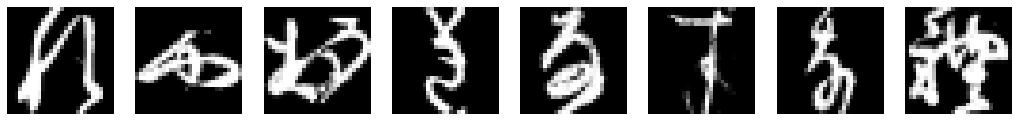

In [17]:
kmnist_dataset = KMNIST('.', train=True, transform=transforms.ToTensor(), download=True)

batch_size = 8
k_data_loader = DataLoader(kmnist_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

x, _ = next(iter(k_data_loader))

fig, axes = plt.subplots(1, x.shape[0], figsize=(18,6))

for i in range(x.shape[0]):
  axes[i].imshow(x[i,0,:,:], cmap="gray")
  axes[i].axis("off")

plt.show()


  0%|          | 0/1500 [00:00<?, ?it/s]

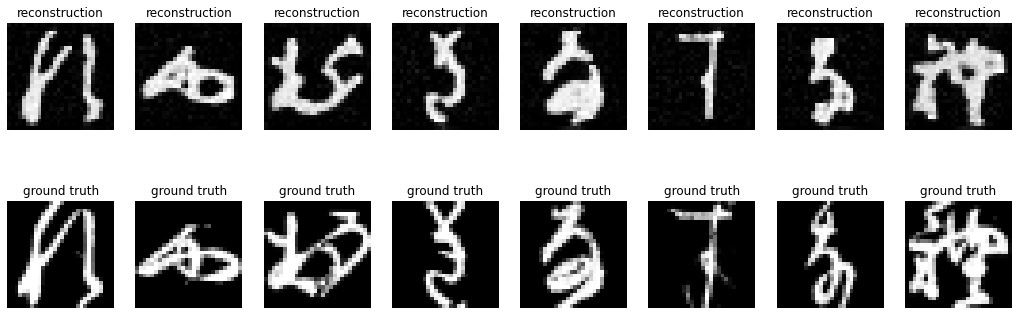

In [18]:
x, _ = next(iter(k_data_loader))
x = x.to(device)
A = A.to(device)

y = torch.matmul(x.view(-1, 784), A.T)
y_delta = y + 0.05*torch.mean(torch.abs(y), dim=1, keepdim=True)*torch.randn_like(y,device=device)

penalty = 30.

samples = condEuler_Maruyama_sampler(score_model, 
                           A=A,
                           y=y_delta,
                           penalty=penalty,
                           drift_coeff=drift_coeff_fn,
                           diffusion_coeff=diffusion_coeff_fn, 
                           num_steps=1500, 
                           device='cuda', 
                           eps=1e-5,
                           T = 1.)
samples = torch.clamp(samples, 0, 1)

fig, axes = plt.subplots(2, samples.shape[0],figsize=(18,6))

for i in range(samples.shape[0]):

  axes[0,i].imshow(samples[i,0,:,:].cpu().numpy(), cmap="gray")
  axes[0,i].axis("off")
  axes[0,i].set_title("reconstruction")
  axes[1,i].imshow(x[i, 0,:,:].cpu().numpy(), cmap="gray")
  axes[1,i].axis("off")
  axes[1,i].set_title("ground truth")

plt.show()

Sometimes we see, that the reconstruction look more like MNIST images than KMNIST images.

On a different example, we approximate a walnut with ellipse phantoms:
![image](https://github.com/Computational-physics-with-learning/Score-based-diffusion/raw/main/walnut.PNG)

## Outlook:

1. Speeding up sampling:
  - Chung et al., *Come-Closer-Diffuse-Faster* (2021): Dont start sampling at $x(T)$, but rather at $x(t') = A^\dagger y^\delta + \eta_{t'}$, i.e. an initial reconstruction with the right amount of noise for time step $t'$. 
  - Model Distillation (e.g. [Salimans and Ho, (2022)](https://openreview.net/forum?id=TIdIXIpzhoI)), i.e. learn a sampler to go from $x(T)$ to $x(0)$ in fewer steps
  - Use other SDE samplers
  - ...

2. More ways of sampling from $p(x|y)$